# [CDAF] Atividade 5

## Nome e matrícula
Nome: Bernardo Vale dos Santos Bento

Matrícula: 2023002065

## Introdução
- Neste notebook, vamos implementar o carregamento dos dados no formato SPADL
- Um modelo de Expected Threat
- Um modelo VAEP com pipeline completa

## Dados
https://figshare.com/collections/Soccer_match_event_dataset/4415000

### Carregando os dados

In [3]:
import numpy as np
import pandas as pd

In [54]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return team_matches

In [55]:
def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players = players[['wyId', 'player_name']].rename(columns={'wyId': 'player_id'})

    return players

In [56]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

    return events

In [37]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(columns={
        'playerId': 'player_id',
        'matchId': 'game_id',
        'teamId': 'team_id',
        'minutesPlayed': 'minutes_played'
    })
    minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)

    return minutes

In [8]:
leagues = ['England', 'Spain']
events = {}
matches = {}
minutes = {}
for league in leagues:
    path = r'matches_{}.json'.format(league)
    matches[league] = load_matches(path)
    path = r'events_{}.json'.format(league)
    events[league] = load_events(path)
    path = r'minutes_played_per_game_{}.json'.format(league)
    minutes[league] = load_minutes_played_per_game(path)

C:\Users\Plusb\AppData\Local\Temp\ipykernel_724\3654259900.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})
C:\Users\Plusb\AppData\Local\Temp\ipykernel_724\3654259900.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})


In [36]:
path = r'players.json'
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

### SPADL

In [10]:
from tqdm import tqdm
import socceraction.spadl as spd

In [11]:
def spadl_transform(events, matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = matches.loc[(matches.matchId == g) & (matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [12]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], matches=matches[league])

100%|██████████| 380/380 [02:09<00:00,  2.94it/s]


## Parte I
- Vamos implementar um modelo de xT usando a biblioteca Socceraction, referenciada abaixo

## Referências
- [1] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.ExpectedThreat.html#socceraction.xthreat.ExpectedThreat
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.get_successful_move_actions.html#socceraction.xthreat.get_successful_move_actions
- [3] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/xT.html

### Questão 1

- Instancie um objeto ExpectedThreat [2] com parâmetros l=25 e w=16.
- Faça o fit do modelo ExpectedThreat com o dataframe "spadl".

In [13]:
from socceraction import xthreat as xt

In [14]:
xt_object = xt.ExpectedThreat(l=25, w=16)
ligas = pd.concat(spadl.values())
modelSpa = xt_object.fit(spadl['Spain'])
model = xt_object.fit(ligas)

# iterations:  29
# iterations:  29


### Questão 2
- Crie um dataframe "prog_actions" à partir do dataframe "spadl", contendo apenas as ações de progressão e que são bem-sucedidas [3].
- Use o método rate do objeto ExpectedThreat p/ calcular o valor de cada ação de progressão do dataframe "prog_actions", em uma coluna chamada "action_value".
- Agrupe o dataframe "prog_actions" por "player_name" e reporte a soma dos "action_value".
- Reporte os 10 jogadores com maior "action_value".

In [38]:
jogadores = pd.read_json('players.json')

jogadores['player_name'] = jogadores['firstName'].fillna('') + " " + \
                    jogadores['middleName'].fillna('') + " " + \
                    jogadores['lastName'].fillna('')


jogadores = jogadores.rename(columns={'wyId': 'player_id'})
jogadores['player_name'] = jogadores['player_name'].apply(lambda x: x.encode('utf-8').decode('unicode_escape') if isinstance(x, str) else x)

In [39]:
prog_actions = xt.get_successful_move_actions(ligas)
prog_actions["action_value"] = model.rate(prog_actions)

valor_jogadores = prog_actions.merge(
                    jogadores[['player_id', 'player_name']],
                    on=['player_id'],
                    how = 'left'
                )

top10 = valor_jogadores.groupby('player_name')['action_value'].sum()
top10 = top10.sort_values(ascending=False).head(10)

print(top10)

prog_actions_spa = xt.get_successful_move_actions(spadl['Spain'])
prog_actions_spa['action_value'] = modelSpa.rate(prog_actions_spa)

valor_jogadores_spa = prog_actions_spa.merge(
    jogadores[['player_id', 'player_name']],
                    on=['player_id'],
                    how = 'left'
                )

top10_spa = valor_jogadores_spa.groupby('player_name')['action_value'].sum()
top10_spa = top10_spa.sort_values(ascending=False).head(10)

print("\nTop 10 espanhol:")
print(top10_spa)

player_name
Kevin  De Bruyne                     14.297634
Marcelo  Vieira da Silva Júnior      11.363641
Lionel Andrés  Messi Cuccittini      10.382351
Alexis Alejandro  Sánchez Sánchez     9.280741
César  Azpilicueta Tanco              9.275931
Francesc  Fàbregas i Soler            8.779873
Álvaro  Odriozola Arzallus            8.652777
Ashley   Young                        8.459524
Christian   Dannemann Eriksen         7.943864
Mesut  Özil                           7.916264
Name: action_value, dtype: float64

Top 10 espanhol:
player_name
Marcelo  Vieira da Silva Júnior    11.363641
Lionel Andrés  Messi Cuccittini    10.382351
Álvaro  Odriozola Arzallus          8.652777
Hugo  Mallo Novegil                 7.820144
Juan Francisco  Moreno Fuertes      7.803691
José Luis  Morales Nogales          7.600214
Roberto José  Rosales Altuve        7.073861
José Luis  Gayá Peña                6.950219
Jordi  Alba Ramos                   6.938634
Éver Maximiliano David  Banega      6.823848
Nam

In [50]:
spadl['Spain'] = spadl['Spain'].merge(
                    jogadores[['player_id', 'player_name']],
                    on='player_id',
                    how = 'left'
                )

spadl['Spain']['player_name'] = spadl['Spain']['player_name'].apply(lambda x: x.encode('utf-8').decode('unicode_escape') if isinstance(x, str) else x)

spadl['England'] = spadl['England'].merge(
                    jogadores[['player_id', 'player_name']],
                    on='player_id',
                    how = 'left'
                )

spadl['England']['player_name'] = spadl['England']['player_name'].apply(lambda x: x.encode('utf-8').decode('unicode_escape') if isinstance(x, str) else x)

## Parte II
- Nessa atividade, temos implementada a pipeline inteira do VAEP [1] para os dados do Wyscout das Top 5 ligas.
- [2] é a documentação das funções do VAEP na API do socceraction.
- [3] apresenta uma explicação do framework com uma mistura de intuição, matemática e código.
- [4] são notebooks públicos que implementam o VAEP para outro conjunto de dados.

## Referências
- [1] https://tomdecroos.github.io/reports/kdd19_tomd.pdf
- [2] https://socceraction.readthedocs.io/en/latest/api/vaep.html
- [3] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/vaep.html
- [4] https://github.com/ML-KULeuven/socceraction/tree/master/public-notebooks

## Instruções
- Para cada header do notebook abaixo, vocês devem explicar o que foi feito e à qual seção/subseção/equação do paper "Actions Speak Louder than Goals: Valuing Actions by Estimating Probabilities" ela corresponde. Justifique suas respostas.
- Além disso, após algumas partes do código haverão perguntas que vocês devem responder, possivelmente explorando minimamente o que já está pronto.
- Por fim, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do VAEP abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

### Features

In [57]:
from socceraction.vaep import features as ft

In [51]:
def features_transform(spadl):
    spadl.loc[spadl.result_id.isin([2, 3]), ['result_id']] = 0 # result == 2 | result == 3 ? result = 0 : result = result
    spadl.loc[spadl.result_name.isin(['offside', 'owngoal']), ['result_name']] = 'fail' # result_name = ('offside' | 'owngoal') ? result_name = 'fail' : result_naem = result_name

    xfns = [ #definicao das features a serem extraidas do evento
        ft.actiontype_onehot,
        ft.bodypart_onehot,
        ft.result_onehot,
        ft.goalscore,
        ft.startlocation,
        ft.endlocation,
        ft.team,
        ft.time,
        ft.time_delta
    ]

    features = []
    for game in tqdm(np.unique(spadl.game_id).tolist()): #para cada jogo 
        match_actions = spadl.loc[spadl.game_id == game].reset_index(drop=True) #acoes do jogo em escopo
        match_states = ft.gamestates(actions=match_actions) # para cada acao do jogo analiza as features acao anterior (estado do jogo)
        match_feats = pd.concat([fn(match_states) for fn in xfns], axis=1) #retira as features preteridas do estado do jogo
        features.append(match_feats) 
    features = pd.concat(features).reset_index(drop=True) #junta todos os estados em um dataFrame

    return features

A função acima itera sobre todos os eventos que ocorreram no jogo, adicionando contexto a eles a partir da função ft.gamestates. A inteção disso é analisar como que cada lance contribuiu num futuro próximo para aumentar/diminuir a probabilidade do time marcar um gol e aumentar/diminuir a chance do time levar um gol. Essa lógica está presente nos primeiros paragrafos da subseção 3.1 e 4.1 do artigo onde ele divide o jogo em estados ( _S_ ) que por sua vez possuem eventos ( _a_ )

1- O que a primeira e a segunda linhas da função acima fazem? Qual sua hipótese sobre intuito dessas transformações? Como você acha que isso pode impactar o modelo final?

O artigo afirma que existem alguns tipos de resultados, basicamente, erro e sucesso são os mais comuns. Para facilitar a análise e padronizar as informações, as primeiras duas linha transformam o resultados "impedido" e "gol-contra" como erro para que eles sejam incluídos na análise seguinte em uma categoria racional.

In [58]:
features = {}
for league in ['England', 'Spain']:
    features[league] = features_transform(spadl[league])

  0%|          | 0/380 [00:00<?, ?it/s]c:\Users\Plusb\Downloads\cdaf\venv\Lib\site-packages\socceraction\vaep\features.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.shift(i, fill_value=float("nan")).fillna(x.iloc[0])  # noqa: B023
c:\Users\Plusb\Downloads\cdaf\venv\Lib\site-packages\socceraction\vaep\features.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.shift(i, fill_value=float("nan")).fillna(x.iloc[0])  # noqa: B023
c:\Users\Plusb\Downloads\cdaf\venv\Lib\site-packages\socceraction\vaep\features.py:94: FutureWarnin

### Labels

In [59]:
import socceraction.vaep.labels as lab

In [60]:
def labels_transform(spadl):
    yfns = [lab.scores, lab.concedes] # probabilidade de fazer gol x probabilidade de levar gol, a partir de uma acao

    labels = []
    for game in tqdm(np.unique(spadl.game_id).tolist()): # para cada partida
        match_actions = spadl.loc[spadl.game_id == game].reset_index(drop=True) # eventos da partida
        labels.append(pd.concat([fn(actions=match_actions) for fn in yfns], axis=1)) # prob gol x prob levar gol para cada evento da partida

    labels = pd.concat(labels).reset_index(drop=True) #junta as probabilidades em um unico dataFrame

    return labels

A função acima normaliza os dados do dicionário spadl para o padrão estabelecido para os estados e adiciona as probabilidade calculadas na função anterior

In [61]:
labels = {}
for league in leagues:
    labels[league] = labels_transform(spadl[league])

100%|██████████| 380/380 [00:11<00:00, 34.04it/s]


In [62]:
labels['England']['scores'].sum() # soma a probabilidade de fazer gols de todas as acoes da liga inglesa

7400

In [63]:
labels['England']['concedes'].sum() # soma a probabilidade de levar gols de todas as acoes da liga inglesa

2465

2- Explique o por que da quantidade de labels positivos do tipo scores ser muito maior que do concedes. Como você acha que isso pode impactar o modelo final?

Todas as acoes sao avaliadas do ponto de vista do time que esta com a posse bola, dessa forma, é muito mais provavel que o time tome decisoes de modo que se aproxime de fazer um gol do que acontecer algum desastre que leve ao gol do adversário.

### Training Model

In [64]:
import xgboost as xgb
import sklearn.metrics as mt

In [65]:
def train_vaep(X_train, y_train, X_test, y_test):
    models = {}
    for m in ['scores', 'concedes']: # para xG a favor e xG contra
        models[m] = xgb.XGBClassifier(random_state=0, n_estimators=50, max_depth=3) 

        print('training ' + m + ' model')
        models[m].fit(X_train, y_train[m])

        #PL

        p = sum(y_train[m]) / len(y_train[m]) # previsao ingenua
        base = [p] * len(y_train[m])
        y_train_pred = models[m].predict_proba(X_train)[:, 1]
        train_brier = mt.brier_score_loss(y_train[m], y_train_pred) / mt.brier_score_loss(y_train[m], base)
        print(m + ' Train NBS: ' + str(train_brier))
        print()

        #Laiga

        p = sum(y_test[m]) / len(y_test[m]) # previsao ingenua
        base = [p] * len(y_test[m])
        y_test_pred = models[m].predict_proba(X_test)[:, 1]
        test_brier = mt.brier_score_loss(y_test[m], y_test_pred) / mt.brier_score_loss(y_test[m], base)
        print(m + ' Test NBS: ' + str(test_brier))
        print()

        print('----------------------------------------')

    return models

A função treina dois modelos de classificação com XGBoost para prever a probabilidade do time marcar e levar um gol em um futuro próximo para cada estado do jogo, o que está diretamente ligado à seção 4 do artigo que aborda o método para estimar as probabilidade para tanto marcar quanto levar um gol

In [66]:
models = train_vaep(X_train=features['England'], y_train=labels['England'], X_test=features['Spain'], y_test=labels['Spain'])

training scores model
scores Train NBS: 0.8450404360168327

scores Test NBS: 0.8520386721558257

----------------------------------------
training concedes model
concedes Train NBS: 0.9669913025392757

concedes Test NBS: 0.9831594131043185

----------------------------------------


3- Por que treinamos dois modelos diferentes? Por que a performance dos dois é diferente?

Quando realizamos o VAEP, queremos levar em consideração a chance de marcar um gol e também de sofrer um gol. Dado esse fato, treinamos os dois modelos, um para prever a chance de realizar um gol e outro para prever a chance de levar um gol

### Predictions

In [67]:
def generate_predictions(features, models): # com o modelo ja treinado, prevemos as probabilidades, no caso, do campeonato espanhol
    preds = {}
    for m in ['scores', 'concedes']:
        preds[m] = models[m].predict_proba(features)[:, 1]
    preds = pd.DataFrame(preds)

    return preds

Com o modelo treinado, atribuí as probabilidades para os estados da base de dados requerida.

In [68]:
preds = {}
preds['Spain'] = generate_predictions(features=features['Spain'], models=models)

### Action Values

In [69]:
import socceraction.vaep.formula as fm

In [86]:
def calculate_action_values(spadl, predictions): # calcula o valor da ação baseada nas predições da probabilidade de marcar um gol x sofrer um gol e agrupa em um dataFrame
    action_values = fm.value(actions=spadl, Pscores=predictions['scores'], Pconcedes=predictions['concedes']) # offensive e defensive values vem daqui
    action_values = pd.concat([
        spadl[['original_event_id', 'action_id', 'game_id', 'player_id', 'player_name', 'start_x', 'start_y', 'end_x', 'end_y', 'type_name', 'result_name']],
        predictions.rename(columns={'scores': 'Pscores', 'concedes': 'Pconcedes'}),
        action_values
    ], axis=1)

    return action_values

Depois de calcular a probabilidade de marcar ou sofrer um gol no futuro próximo, a função acima calcula o impacto que cada ação (evento) teve para aumentar ou diminuir ambas as chances. Isso está específicado no final da subseção 3.1 na equação V ( ai, x ) = delta( Pscores( ai, x )) - delta( Pconcedes( ai,x ) )

In [87]:
action_values = {}
action_values['Spain'] = calculate_action_values(spadl=spadl['Spain'], predictions=preds['Spain'])

acoes_alto_valor = action_values['Spain'][action_values['Spain']['Pscores'] >= 0.95]
nome_acoes = acoes_alto_valor['type_name'].unique()
print(nome_acoes)

acoes_alto_valor.loc[:, 'distance'] = np.sqrt(
    ((100 - acoes_alto_valor['start_x']) * 105 / 100)**2 +
    (abs(acoes_alto_valor['start_y'] - 50) * 68 / 100) **2
)
print(acoes_alto_valor['distance'].mean())

# todas foram penaltis ou chutes a uma distância media de 13 metros (a marca do penalti fica a 11 metros)

acoes_baixo_valor = action_values['Spain'][
    (action_values['Spain']['Pscores'] <= 0.95) & 
    (action_values['Spain']['type_name'].isin(nome_acoes))
]

acoes_baixo_valor.loc[:, 'distance'] = np.sqrt(
    ((100 - acoes_baixo_valor['start_x']) * 105 / 100)**2 +
    (abs(acoes_baixo_valor['start_y'] - 50) * 68 / 100) **2
)
print(acoes_baixo_valor['distance'].mean())

# chutes com valor menor que 0.95 tiveram distância media de 17,4 metros. A grande área tem 16,5m de largura

['shot' 'shot_penalty']
13.191798754021637
17.422774715809105


C:\Users\Plusb\AppData\Local\Temp\ipykernel_724\3605201989.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acoes_alto_valor.loc[:, 'distance'] = np.sqrt(
C:\Users\Plusb\AppData\Local\Temp\ipykernel_724\3605201989.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acoes_baixo_valor.loc[:, 'distance'] = np.sqrt(


In [72]:
import matplotlib.pyplot as plt

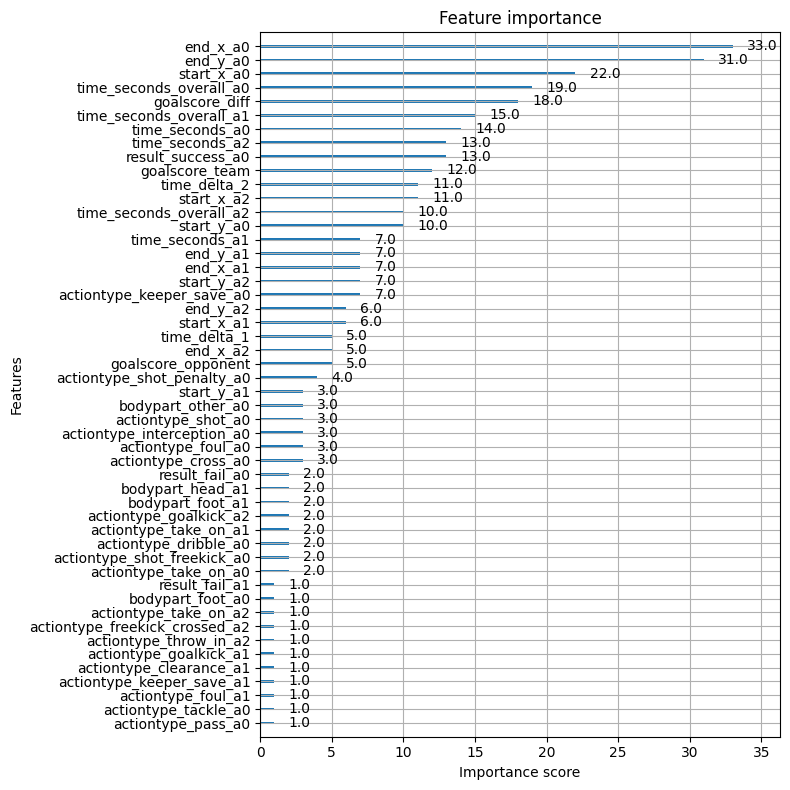

In [73]:
xgb_model = models['scores']  # Assumindo que 'scores' é o modelo de previsão de gol

fig, ax = plt.subplots(figsize=(8, 8))  # Altura maior = mais espaço entre os rótulos

xgb.plot_importance(models['scores'], importance_type='weight', ax=ax)

plt.tight_layout()
plt.show()

4- Explore as ações com Pscores >= 0.95. Por que elas tem um valor tão alto? As compare com ações do mesmo tipo e resultado opostado. Será que o modelo aprende que essa combinação de tipo de ação e resultado está diretamente relacionado à variável y que estamos tentando prever?

As únicas ações que obtiver Pscores tão altos foram chutes e penaltis. O único fato além disso que podemos extrair de action_values e a distancia do gol, onde quando a probabilidade e maior que 0.95 a distancia media e 13 metros e quando e menor dee 0.95 a distancia media e 17 metros. E esperado que isso tenha um impacto grande no modelo e para confirma isso vemos o grafico da importancia das features do modelo['scores']. Nesse grafico percebemos que a distancia final e muito importante, o que acaba so confirmando um vies (e claro que a probabilidade de gol vai ser grande quando a bola termina na cordenada do gol), apesar disso, a terceira variavel mais importante e a cordenada x original, o que demonstra a importancia da distancia que observamos no inicio.

5- Qual formula do paper corresponde à coluna 'offensive_value' do dataframe action_values? E a coluna 'defensive_value'?

Subseção 3.1:

offensive_value = Pscores( Si, x ) - Pscores ( Si-1, x )

offensive_value = Pconcedes( Si, x ) - Pconcedes ( Si-1, x )


### Player Ratings

In [19]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby('player_id', as_index=False)['minutes_played'].sum()

    return minutes_per_season

In [20]:
minutes_per_season = {}
minutes_per_season['Spain'] = calculate_minutes_per_season(minutes['Spain'])

In [74]:
def calculate_player_ratings(action_values, minutes_per_season, players):
    player_ratings = action_values.groupby(by='player_id', as_index=False).agg({'vaep_value': 'sum'}).rename(columns={'vaep_value': 'vaep_total'})
    player_ratings = player_ratings.merge(minutes_per_season, on=['player_id'], how='left')
    player_ratings['vaep_p90'] = player_ratings['vaep_total'] / player_ratings['minutes_played'] * 90
    player_ratings = player_ratings[player_ratings['minutes_played'] >= 600].sort_values(by='vaep_p90', ascending=False).reset_index(drop=True)
    player_ratings = player_ratings.merge(players, on=['player_id'], how='left')
    player_ratings = player_ratings[['player_id', 'player_name', 'minutes_played', 'vaep_total', 'vaep_p90']]

    return player_ratings

Finalmente, com os dados calculados, podemos escolher como trata-los. No caso, foi escolhido agregar os dados por jogadores, desse modo, realizamos um somatório para cada jogador do V calculado na função calculate_action_values de cada evento onde ele é responsável por tomar a decisão. Para enriquecer ainda mais nossos dados, multiplicamos o resultado por 90/(minutos jogados pelo jogador) para normalizar os dados, permitindo fazer comparações mais justas. Estes fatos estão declarados na subseção 3.2 do artigo

In [48]:
top10_spa = valor_jogadores_spa.groupby(['player_id', 'player_name'], as_index=False)['action_value'].sum()

top10_spa = top10_spa.merge(minutes_per_season['Spain'],
                          on='player_id',
                          how='left'
)

top10_spa['action_value_90'] = top10_spa['action_value'] * 90 / top10_spa['minutes_played']

print(top10_spa[['player_name', 'action_value_90']].sort_values(by='action_value_90',ascending=False).head(10))


                         player_name  action_value_90
367            Ager  Aketxe Barrutia         1.022326
473         Benito  Ramírez del Toro         0.542329
22   Marcelo  Vieira da Silva Júnior         0.439316
210  Miguel Ángel  Garrido Cifuentes         0.386553
363       João Pedro  Cavaco Cancelo         0.378534
198                David  Juncà Reñé         0.360408
192          Lucas  Vázquez Iglesias         0.346625
90   Jefferson Antonio  Montero Vite         0.344243
100            Carlos  Martínez Díez         0.323632
199         Carles  Planas Antolínez         0.317225


In [76]:
player_ratings = {}
player_ratings['Spain'] = calculate_player_ratings(action_values=action_values['Spain'], minutes_per_season=minutes_per_season['Spain'], players=jogadores)

print(player_ratings['Spain'][['player_name', 'vaep_p90']].sort_values(by='vaep_p90', ascending=False).head(10))

                            player_name  vaep_p90
0       Lionel Andrés  Messi Cuccittini  1.066348
1                    Gareth Frank  Bale  0.707023
2       Arnaldo Antonio  Sanabria Ayala  0.662769
3  Cristiano Ronaldo  dos Santos Aveiro  0.660991
4                    Antoine  Griezmann  0.604660
5            Philippe  Coutinho Correia  0.594033
6                    Iago  Aspas Juncal  0.580114
7             Luis Alberto  Suárez Díaz  0.556248
8                    Iker  Muniain Goñi  0.548573
9                Santiago  Mina Lorenzo  0.540084


6- Acha que o Top 5 da lista é bem representativo? Compare esse ranqueamento do VAEP com o do xT da Parte I. Qual você acha que é mais representativo?

A segunda lista é bem mais representativa e contém nomes mais esperados, como Suaréz e Griezmann que não apareceram primeiramente. Apesar disso, a primeira lista não é totalmente descatável, afinal ela é mais democrática em distribuir o nível de importância de um jogador para várias posições do time, levando a jogadores que atuam por "trás dos holofotes".